In [1]:
##############################################################################
#
# This code is part of the publication:
# https://www.biorxiv.org/content/10.1101/2020.11.30.403840v1
#
# The generation of cortical novelty responses through inhibitory plasticity
# Auguste Schulz*, Christoph Miehl*, Michael J. Berry II, Julijana Gjorgjieva
#
# * equal contribution
#
##############################################################################

# Figure sequence violation paradigm

specify the filename below to check if the simulation was successful

run the following command from 'main' and then copy the corresponding file name

> nohup julia initsim_sequence_violation_ARGS.jl 3 20 10 1 300 12 5 10 0 10 &> ../tmp/standard_run_unique_sequence.txt &

In [2]:
from IPython.display import HTML, IFrame, Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os, fnmatch
import time
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy import stats
from scipy import optimize
from scipy.signal import decimate
from scipy import signal
import gc
import time

%matplotlib inline


from matplotlib import rcParams, cm
rcParams['grid.linewidth'] = 0
rcParams['pdf.fonttype'] = 42
# import custom functions
from helper_functions import *
import helper_functions

#reload(helper_functions)
from helper_functions import *

from evaluation_functions import *
import evaluation_functions

#reload(evaluation_functions)
from evaluation_functions import *

In [3]:
# few simulations 10 sequences 1 block
file_names = [
    "Seq_Violation_0.1_dur7000.0msNblocks1Ntrain5lenstim30lenpause0Nreps10strength12wadaptfalseiSTDPtrueRateAdjust1.0Time2020-12-16-17-47-49repeatedsequences.h5"
    ]

In [4]:
avgwindow = 4
timestr = time.strftime("%Y-%m-%d-%H-%M-%S")

RUN_DIR = "../data/"
RESULTS_DIR = "../results/"

# load the spiketimes and bin them accorindlingly into excitatory population response, time bin (ed)
for i,fn in enumerate(file_names):
    E, I, ed, E_hist, E_hist_boxcar, FIG_DIR, E_nov = analyse_filename(fn, avgwindow=avgwindow, timestr=timestr)

    

# calculate spiketimes for raster plots
file_name = file_names[0] # first filename

file_name_results = RESULTS_DIR + file_name + "/results.h5"

# read in run parameters
file_name_run = RUN_DIR + file_name
# open file
frun = h5py.File(file_name_run, "r")

# read in stimulus parameters
Nimg, Nreps, Nseq, Nblocks, stimstart, lenstim, lenpause, strength  = frun["initial"]["stimparams"].value
Ni = frun["params"]["Ni"].value
Ne = frun["params"]["Ne"].value
Ncells = Ni + Ne


seqnumber  = frun["initial"]["seqnumber"].value
assemblymembers = frun["initial"]["assemblymembers"].value.transpose()
color = ["midnightblue","lightskyblue","royalblue","lightsteelblue","darkred","darksalmon", "saddlebrown","lightcoral","darkgreen","greenyellow","darkolivegreen","chartreuse","darkmagenta","thistle","indigo","mediumslateblue","darkorange","tan","sienna","orange", "midnightblue","lightskyblue","royalblue","lightsteelblue","darkred","darksalmon", "saddlebrown","lightcoral","darkgreen","greenyellow","darkolivegreen","chartreuse","darkmagenta","thistle","indigo","mediumslateblue","darkorange","tan","sienna","orange"]

Nass = Nimg*Nseq

# read in population averages
listOfFiles = os.listdir(RESULTS_DIR + file_name)
pattern = "spiketime*.h5"
sub_folder = []

for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            sub_folder.append(entry)

# get name of subfolder spiketime + date.h5
file_name_spikes = RESULTS_DIR + file_name + "/" + sub_folder[0]
f = h5py.File(file_name_spikes, "r")

lenblocktt  = f["params"]["lenblocktt"].value
blockbegintt  = f["params"]["blockbegintt"].value
dt = 0.1

# only load first sequence and first block
Nseq=1
Nblocks=1

total_spike_counts = np.zeros((Nseq,Nblocks,Ncells))


for seq in range(1,Nseq + 1):
    for bl in range(1,Nblocks + 1):
        # read in spiketimes
        spiketimes = f["spiketimeblocks"]["seq"+ str(seq) + "block"+ str(bl)].value.transpose()

        # rebin spiketimes in binsize of 100 ms
        for cc in range(0,Ncells):
            total_spike_counts[seq-1,bl-1,cc] = sum(spiketimes[cc,:]>0)
        gc.collect()

/home/auguste/Software/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


NON ADAPTIVE


[Text(0, 0.5, 'unsorted neurons'), Text(0.5, 0, 'time [s]')]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


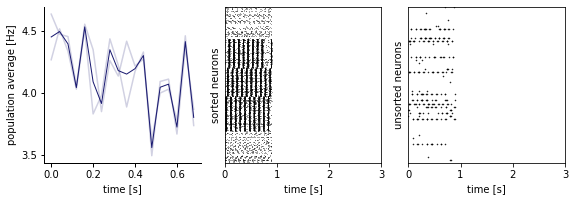

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


axiswidth=1
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
figsize_cm = (20,6.8)
figsize_inch = cm2inch(figsize_cm)
figsize_inch
fig1 = plt.figure(constrained_layout=True, figsize=figsize_inch)
gs = fig1.add_gridspec(1,3, hspace=3, wspace = 1)

f1_ax1 = fig1.add_subplot(gs[0,0]) 

f1_ax2 = fig1.add_subplot(gs[0,1]) 

f1_ax3 = fig1.add_subplot(gs[0,2])


for aa, ax in enumerate([f1_ax1]):
    for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(axiswidth)
    for axis in ['top', 'right']:
        ax.spines[axis].set_linewidth(0)
    ax.xaxis.set_tick_params(width=axiswidth)
    ax.yaxis.set_tick_params(width=axiswidth)
    ax.locator_params(tight=True, nbins=4)
# # ================================================ population average =================================================

for hist in E:
    f1_ax1.plot(ed[:-5],hist[:-5], color='midnightblue', alpha = 0.2)
f1_ax1.set_xlabel("time [s]")
f1_ax1.set_ylabel("population average [Hz]")
# plot mean across all blocks in opaque
f1_ax1.plot(ed[:-5],np.mean(E,axis=0)[:-5], color='midnightblue',lw=axiswidth)
f1_ax1.xaxis.set_tick_params(width=axiswidth)
f1_ax1.yaxis.set_tick_params(width=axiswidth)
#plt.tight_layout()

# ================================================ rasters =================================================
sq=0
bl=0

fontsize = 10
N_neurons = 50
rowcount = 0
Nmaxmembers=300
# add first 200 neurons
for cc in range(200):
    rowcount+=1    
    vals = spiketimes[cc,:int(np.rint(total_spike_counts[sq,bl,cc]))]/10000
    y = rowcount*np.ones(len(vals))
    f1_ax2.scatter(vals,y,s=1,marker=".",c = 'black',linewidths=0)
    
# add 3 assemblies on top of each other
for pp in range(Nass):#1:int(Nass):
#    print("population ",pp)
    for cc in range(Nmaxmembers):
        if assemblymembers[pp,cc] < 1:
            break

        rowcount+=1
        ind = int(assemblymembers[pp,cc])-1 # PyIdx = Oython index starts from 0 julia from 1        
        vals = spiketimes[ind,:int(np.rint(total_spike_counts[sq,bl,ind]))]/10000
        y = rowcount*np.ones(len(vals))
        if pp <= Nass:
            f1_ax2.scatter(vals,y,s=1,marker=".",c = 'black',linewidths=0)
        else:
            f1_ax2.scatter(vals,y,s=1,marker=".",c = "black",linewidths=0)

# add 200 neurons on top
for cc in range(1500,1700):
    rowcount+=1    
    vals = spiketimes[cc,:int(np.rint(total_spike_counts[sq,bl,cc]))]/10000
    y = rowcount*np.ones(len(vals))
    f1_ax2.scatter(vals,y,s=1,marker=".",c = 'black',linewidths=0)
f1_ax2.set_xlim(0, 3)
f1_ax2.set_ylim(0,sum(sum(assemblymembers[:3,:]>0))+400)

f1_ax2.set(
ylabel="sorted neurons",
xlabel="time [s]")
f1_ax2.locator_params(tight=True, nbins=3)
f1_ax2.set_yticks([]);


# ================================================ unsorted raster 50 =================================================

#plot raster with Nneuron neurons (unsorted)
rowcount = 0
Nmaxmembers=300
for cc in range(N_neurons):
    rowcount+=1    
    vals = spiketimes[cc,:int(np.rint(total_spike_counts[sq,bl,cc]))]/10000
    y = rowcount*np.ones(len(vals))
    f1_ax3.scatter(vals,y,s=1,marker=".",c = 'black',linewidths=1)
f1_ax3.set_xlim(0, 3)
f1_ax3.set_ylim(0,N_neurons)
f1_ax3.locator_params(tight=True, nbins=3)
f1_ax3.set_yticks([]);

f1_ax3.set(
ylabel="unsorted neurons",
xlabel="time [s]")